<a href="https://colab.research.google.com/github/VandvC/finetune_llama7b/blob/fix_same_output/fine_tune_mistral_7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hands On] Fine Tuning Mistral 7b

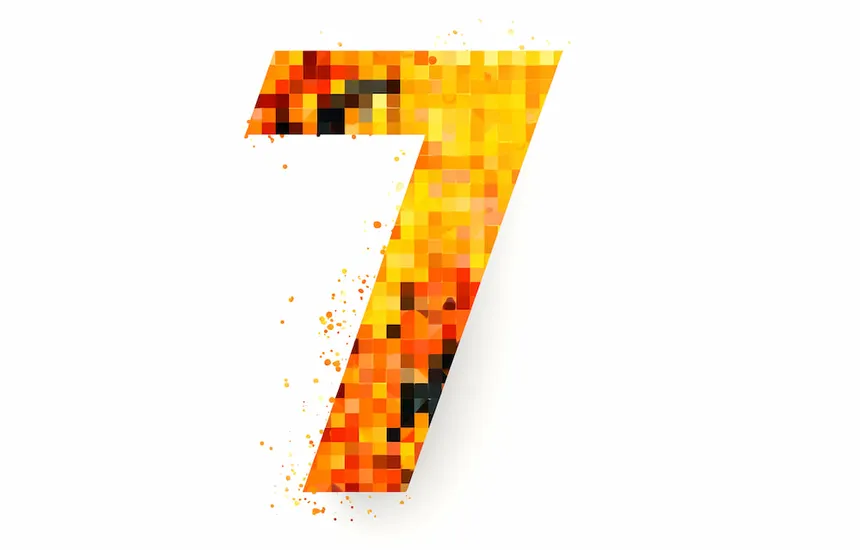

## Boilerplates / Import ..

### Install needed packages

Just run the cells below

In [ ]:
# !pip install scipy

In [ ]:
!python --version

Python 3.10.12


In [ ]:
%pip install --upgrade pip --quiet
%pip install --disable-pip-version-check \
    torch \
    torchdata==0.5.1 --quiet

%pip install -q -U trl git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git --quiet

%pip install \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    trl \
    sentencepiece \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    accelerate==0.21.0 --quiet

%pip install bitsandbytes==0.41.3.post2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 50.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 requires torchdata==0.7.0, but you have torchdata 0.5.1 

### GPU available ?

Double check we are on **GPU**

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [ ]:
# Output the GPU name, device etc..
!nvidia-smi

Wed Dec 20 11:07:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

torch.version.cuda

'11.7'

In [ ]:
!python -m bitsandbytes | grep False

False

===================================BUG REPORT===================================
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('8013'), PosixPath('http')}
The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url

## If torch CUDA version does not match System CUDA version AND `!python -m bitsandbytes` display an error

Go to the [cuda archive link](https://developer.nvidia.com/cuda-toolkit-archive) and follow the steps from [this post](https://stackoverflow.com/a/74561909) in order to install the cuda version that match the version specified by `torch.version.cuda`.


In [ ]:
%%capture --no-stderr
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!dpkg -i cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!cp /var/cuda-repo-ubuntu2204-11-7-local/cuda-*-keyring.gpg /usr/share/keyrings/
!apt-get update
!apt-get -y install cuda-11-7

--2023-12-20 11:08:06--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2204.pin’

cuda-ubuntu2204.pin 100%[===================>]     190  --.-KB/s    in 0s      

2023-12-20 11:08:07 (5.42 MB/s) - ‘cuda-ubuntu2204.pin’ saved [190/190]

--2023-12-20 11:08:07--  https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
# Now the following command should output SUCCESS

!python -m bitsandbytes | grep SUCCESS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++ BUG REPORT INFORMATION ++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

++++++++++++++++++ /usr/local CUDA PATHS +++++++++++++++++++
/usr/local/lib/python3.10/dist-packages/torch/lib/libc10_cuda.so
/usr/local/lib/python3.10/dist-packages/torch/lib/libtorch_cuda_cpp.so
/usr/local/lib/python3.10/dist-packages/torch/lib/libtorch_cuda.so
/usr/local/lib/python3.10/dist-packages/torch/lib/libtorch_cuda_linalg.so
/usr/local/lib/python3.10/dist-packages/torch/lib/libtorch_cuda_cu.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda122.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda122_nocublaslt.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbyt

In [ ]:
%pip show bitsandbytes

Name: bitsandbytes
Version: 0.41.3.post2
Summary: k-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


### General Import

In [ ]:
from typing import List, Dict, Optional, Union, Any

## Dataset preparation

For our experiment, we will use the Zelros Insurance dataset in French, which is small density high quality dataset used to answer questions related to insurance.

The dataset can be found [here](https://huggingface.co/datasets/zelros/insurance-fr).

Some transformation will be done on dataset to ensure we follow good guidelines to fine tune a model.
Transformations include :


*   🗣️ Ensuring the preprompt gives context related to insurance
*   💬 prepare instruction and response template



In [ ]:
import datasets
from datasets import load_dataset

dataset_name: str = "zelros/insurance-fr"

################################################################################
# Data set loading
################################################################################
dataset_raw: datasets.arrow_dataset.Dataset = (
    load_dataset(
        dataset_name,
        split="train"
    )
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/zelros___csv/zelros--insurance-fr-8ff53c58d6bb9084/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


In [ ]:
print(type(dataset_raw))
dataset_raw[0]

<class 'datasets.arrow_dataset.Dataset'>


{'title': "Qu'est-ce que l'assurance responsabilité civile des enfants",
 'content': 'L’assurance responsabilité civile des enfants permet de prendre en charge les dommages corporels et matériels que votre enfant cause à un tiers. Généralement incluse dans votre assurance habitation, cette garantie est également couverte par l’assurance scolaire. Quelle solution choisir pour couvrir au mieux vos enfants ?'}

We need to convert the dialog-answer (prompt 'title' - response 'content') pairs into explicit instructions for the LLM. we pretend an instruction to the start of the dialog with `Ici, le client est un client d'une société d'assurance qui pose une question [...]`

In [ ]:
################################################################################
# prompt template
################################################################################

# `pre_prompt` gives the context related to insurance.
pre_prompt: str = (
    "Question Réponse entre un client et un expert en assurance."
)

# `question_template` introduces the user question.
question_template: str = "### Question du client:"

# `instruction_template` mixes pre_promt AND question template
instruction_template: str = pre_prompt + question_template

# `response_template` introduces the assistant answer.
response_template: str = "### Réponse de l'expert en assurance:"


In [ ]:
################################################################################
# utils functions
################################################################################

def promptize_input(
    data: Dict[str, str],
    add_answer: bool = False
  ) -> str:
  """
  Allows to generate prompt with context preprompt, question and optional answer.

  Parameters
  ----------
  data: Dict[str, str]
  add_answer: bool, by default False
    If `add_answer`, add the correct output of the dataset.


  Returns
  -------
  str
  """
  human: str = (
      f"{instruction_template}\n {data['title']}\n"
  )
  final_prompt = human

  if add_answer:
    assistant: str = f"{response_template}\n {data['content']}"
    final_prompt += assistant

  return final_prompt


In [ ]:
################################################################################
# dataset transformation
################################################################################
new_column: List[str] = []

for _, data in enumerate(dataset_raw):
  new_column.append(
      promptize_input(data=data, add_answer=True)
  )

print(new_column[45])

# adding new column (to remove use `dataset.remove_columns(["text"])`)
dataset = (
    dataset_raw.add_column(
        "text",
        new_column
    )
)

# split the dataset in train and test
dataset = dataset.train_test_split(test_size=0.1)

Question Réponse entre un client et un expert en assurance.### Question du client:
 L’assurance locative est-elle obligatoire ?
### Réponse de l'expert en assurance:
 Si vous êtes locataire d’un logement, que ce soit un appartement, une maison ou un studio, la loi du 6 juillet 1989 vous oblige à souscrire une assurance habitation auprès de l’assureur de votre choix. Mais seule la garantie « risques locatifs » est obligatoire.
 
A noter : votre propriétaire est en droit d’exiger une attestation d’assurance habitation :

- lors de la signature du bail de location,
- chaque année à la date anniversaire de la signature du bail.

En l’absence de ce justificatif, le bailleur peut renoncer à signer le bail ou le résilier de plein droit.


In [ ]:
print(type(dataset["train"]))
dataset

<class 'datasets.arrow_dataset.Dataset'>


DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'text'],
        num_rows: 180
    })
    test: Dataset({
        features: ['title', 'content', 'text'],
        num_rows: 21
    })
})

In [ ]:
################################################################################
# compare original dataset vs transformed dataset
################################################################################
import random

random_idx: int = random.randint(0, len(dataset["train"]) - 1)

# Initial dataset
print("=" * 50 + "  INITIAL DATASET  " + "="*50 + "\n\n")
print(dataset["train"][random_idx]["title"])
print(dataset["train"][random_idx]["content"])


# refined dataset
print("\n\n" + "=" * 50 + "  REFINED DATASET  " + "="*50 + "\n\n")
print(dataset["train"][random_idx]["text"])

==================================================  INITIAL DATASET  ==================================================


Comment recevoir son attestation d’assurance habitation MMA ?
Si vous êtes assuré chez MMA, votre attestation d'assurance habitation vous est systématiquement transmise par courrier ou par e-mail lors de la souscription du contrat et au moment de son renouvellement annuel.
Vous n’avez rien reçu ? Vous pouvez obtenir votre attestation d’assurance habitation(7) en ligne depuis votre Espace Client. Une fois connecté, vous avez accès à l'ensemble de vos contrats et des attestations relatives.
Si vous préférez, vous pouvez également en faire la demande à votre agent MMA, soit par téléphone, par e-mail, depuis votre Espace Client ou même directement en agence.


==================================================  REFINED DATASET  ==================================================


Question Réponse entre un client et un expert en assurance.### Question du client:
 Comment

## Models (and needed *layers*) + Tokenizer

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer
)
from trl import DataCollatorForCompletionOnlyLM

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


### Bits and Bytes loading



Quick reminder about difference in **Normal** vs **Brain** Float.

As explained in this [huggingface chat](https://huggingface.co/PygmalionAI/pygmalion-7b/discussions/3#644f684428774bd665cea8f5):


*Standard 16-bit floats weren't really designed for AI, they have better precision than bfloats (which is better for most use-cases), but also store a smaller range than 32-bit floats do (which affects prediction quality). It's also much easier to convert from 32-bit float to 16-bit bfloat since you only have to truncate the mantissa bits down to 16-bit.*



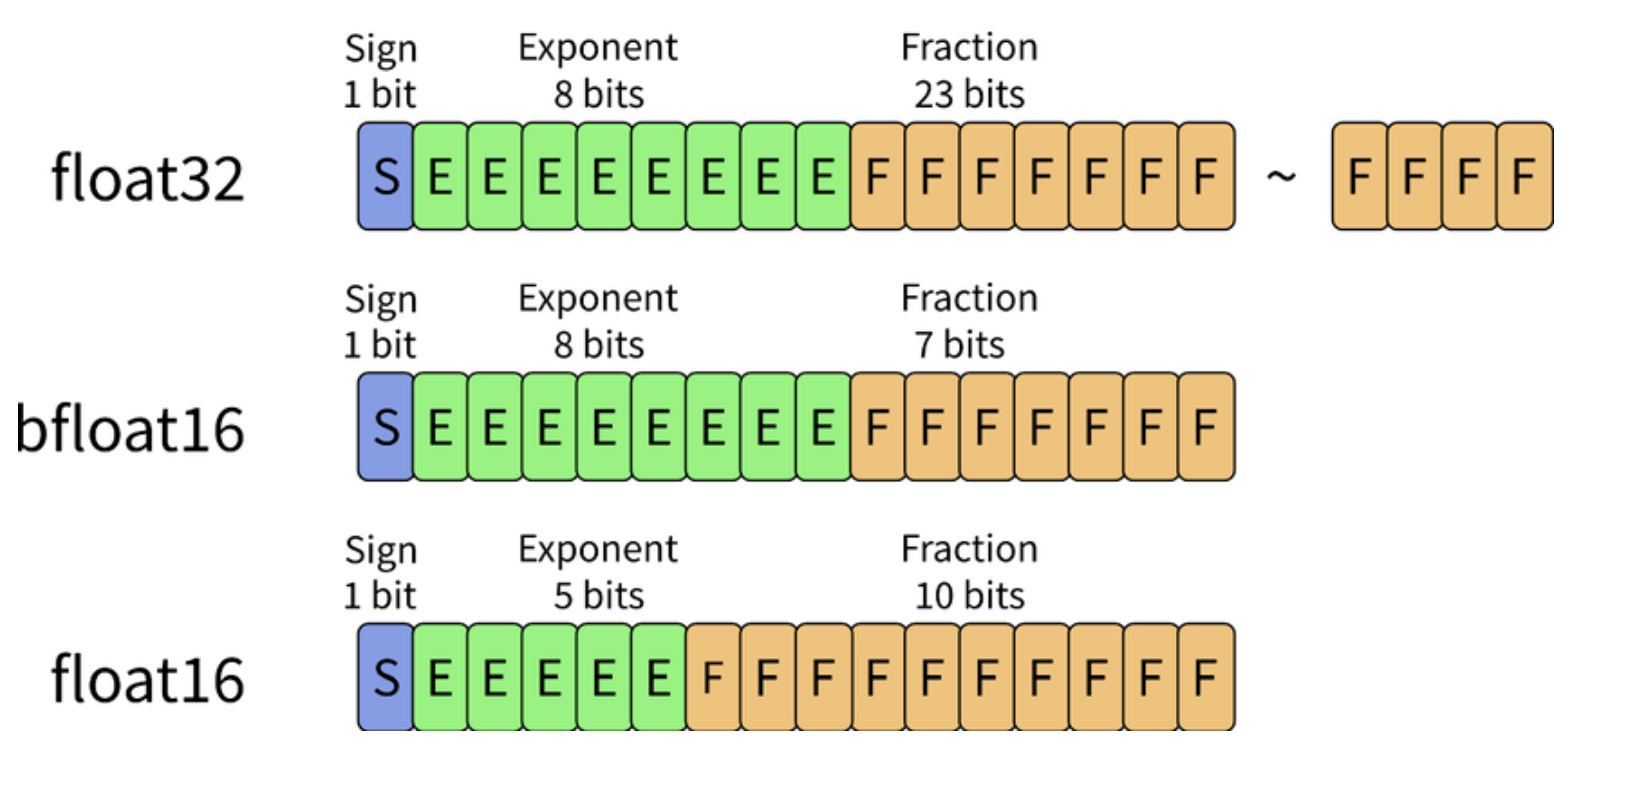

In [ ]:
################################################################################
# bitsandbytes parameters
################################################################################

# More information here :
# https://huggingface.co/docs/transformers/main_classes/quantization

# Activate 4-bit precision base model loading
load_in_4bit: bool = True

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type: str = "nf4"

# Compute dtype for 4-bit base models
compute_dtype: str = "float16"
bnb_4bit_compute_dtype = getattr(torch, compute_dtype)
assert bnb_4bit_compute_dtype == torch.float16

# Activate nested quantization for 4-bit base models (double quantization)
bnb_4bit_use_double_quant = False

################################################################################
# bitsandbytes loading
################################################################################
bnb_config = BitsAndBytesConfig(
    load_in_4bit=load_in_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=bnb_4bit_use_double_quant,
)

### Mistral 7b Model loading

In [ ]:
################################################################################
# model parameters
################################################################################

# Model name to find on HuggingFace.
# Here we take a sharded model so it fits on single GPU during loading
model_name: str = (
  "ybelkada/Mistral-7B-v0.1-bf16-sharded"
)
# Load the entire model on the GPU 0
# Please note that device_map=auto should be used for inference only.
device_map: Dict[str, int] = {
    "": 0
}

################################################################################
# model raw loading
################################################################################

model_name: str = (
  "ybelkada/Mistral-7B-v0.1-bf16-sharded"
)
model_raw = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)
model_raw.config.use_cache = False

# Necessary to ensure exact reproducibility of the pretraining results.
model_raw.config.pretraining_tp = 1



config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
print("="*180)
print("Printing the model (with `print(model)` is needed to indentify the `target_modules` in LoraConfig")
print("="*180)

#print(model)

Printing the model (with `print(model)` is needed to indentify the `target_modules` in LoraConfig


### Tokenizer loading

In [ ]:
################################################################################
# tokenizer loading
################################################################################
model_name: str = (
  "ybelkada/Mistral-7B-v0.1-bf16-sharded"
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    # trust_remote_code=True
)

# padding
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_special_tokens({"pad_token": "<pad>"})

# Fix weird overflow issue with fp16 training
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/145 [00:00<?, ?B/s]

In [ ]:
tokenizer.__class__.__name__

'LlamaTokenizerFast'

## Test the Model with Zero Shot Inferencing

In [ ]:
index = 6 # max is 21

################################################################################
# prepare prompt
################################################################################
answer = dataset["test"][index]["content"]
prompt = promptize_input(
    data=dataset["test"][index],
    add_answer=False
)
instruction = prompt + response_template
print(instruction)

Question Réponse entre un client et un expert en assurance.### Question du client:
 Quels sont les principaux risques pour un propriétaire bailleur ?
### Réponse de l'expert en assurance:


In [ ]:
################################################################################
# generate the output
################################################################################

# ensuring device is GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is : ", device)

# tokenizer + mapping to GPU
inputs = tokenizer(instruction, return_tensors="pt").to(device)

# generation of text
output = tokenizer.decode(
    model_raw.generate(
        inputs["input_ids"],
        pad_token_id=tokenizer.pad_token_id, # avoids warning
        max_new_tokens=128,
    )[0],
    skip_special_tokens=True
)

# display output
dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{answer}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

device is :  cuda


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Question Réponse entre un client et un expert en assurance.### Question du client:
 Quels sont les principaux risques pour un propriétaire bailleur ?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Les problèmes les plus fréquents sont les dommages conséquents à des sinistres divers (fuites ; incendie…), les dégradations constatées au moment du départ du locataire et les loyers impayés. Plusieurs garanties liées au contrat d’assurance du propriétaire non-occupant couvrent ces différents cas de figure, comme par exemple la GLI (garantie loyers impayés), qui est une garantie optionnelle, et les garanties dégât des eaux et incendie, incluses dans toutes les formules d’assurance PNO de MMA.

---------------------------------------------------------------------------------------------------
MODEL GENERA

## Load the Lora module

Below we will load the configuration file in order to create the LoRA model. According to QLoRA paper, it is important to consider all linear layers in the transformer block for maximum performance. Therefore we will add `gate_proj`, `up_proj` and `down_proj` layers in the target modules in addition to the mixed query key value layer.

LoRAs are residual layers that add A B * scaling to the original output, where A and B are low rank matrices and scaling is a constant given by alpha / rank. The weight initialization is independent of alpha.


In [ ]:
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training
)

In [ ]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension, rank to reduce the matrix
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

# module to apply rank reduction on
target_modules: List[str] = [
    "q_proj", # self attention query
    "k_proj", # self attention key
    "v_proj", # self attention value
    "o_proj", # self attention value
    "gate_proj", # feed forward after attention
    "up_proj", # feed forward after attention
    "down_proj", # feed forward after attention
]

# Causal language modeling, not 'masked' as it is decoder
task_type: str = "CAUSAL_LM"

################################################################################
# QLoRA loading
################################################################################

peft_config = LoraConfig(
    lora_alpha=lora_alpha,  # Scaling the weight
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type=task_type,
    target_modules=target_modules
)

## Loading the trainer
Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

In [ ]:
################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir: str = "./results"

# Number of training epochs
num_train_epochs: int = 3

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16: bool = True
bf16: bool = False

# Check GPU compatibility with bfloat16 compute
if bnb_4bit_compute_dtype == torch.float16 and load_in_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)
        fp16: bool = False
        bf16: bool = True

# Batch size per GPU for training
per_device_train_batch_size: int = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size: int = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps: int = 4

# Maximum gradient normal (gradient clipping)
max_grad_norm: float = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate: float = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay: float = 0.001

# Optimizer to use
optim: str = "paged_adamw_32bit"

# Learning rate schedule 'cosine' or 'constant'
lr_scheduler_type: str = "cosine"

# Number of training steps (overrides num_train_epochs if > 0)
max_steps: int = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio: float = 0.03

# Group sequences into batches with roughly the same length
# Saves memory by miminizing padding and speeds up training considerably
# Only useful if applying dynamic padding.
group_by_length: Optional[bool] = False

# Save checkpoint every X updates steps
save_steps: int = 5

# Log every X updates steps
logging_steps: int = 5

# Gradient checkpointing is a technique in deep learning
# that selectively stores checkpoints during the backpropagation process,
# reducing memory consumption by avoiding the need to store all intermediate states.
gradient_checkpointing: bool = True

# show loss at each step / epoch
evaluation_strategy: str = "steps"


In [ ]:
################################################################################
# TrainingArguments loading
################################################################################

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=gradient_checkpointing,
    # report_to="tensorboard"
)

In [ ]:
################################################################################
# SFT Trainer parameters
################################################################################

# train test eval
dataset_text_field: str = "text"
dataset_train_key: str = "train"
dataset_eval_key: str = "test"

# Maximum sequence length to use
max_seq_length: Optional[int] = 512

# SFTTrainer supports example packing,
# where multiple short examples are packed in the same input sequence,
# to increase training efficiency, not compatible with datacollator
packing: bool = True

# Load the entire model on the GPU 0
device_map: Dict[str, int] = {"": 0}


In [ ]:
type(dataset["train"])


datasets.arrow_dataset.Dataset

In [ ]:
################################################################################
# SFT Trainer Loading
################################################################################

# Init the trainer
trainer = SFTTrainer(
    model=model_raw,
    train_dataset=dataset[dataset_train_key],
    # eval_dataset=dataset[dataset_eval_key],
    peft_config=peft_config,
    dataset_text_field=dataset_text_field,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing
)


We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [ ]:
# Cast the layernorm in fp32, make output embedding layer require grads,
# add the upcasting of the lmhead to fp32
# model_raw = prepare_model_for_kbit_training(model_raw)

# Cast the layernorm in fp32, make output embedding layer require grads,
# add the upcasting of the lmhead to fp32
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Now let's train the model! Simply call `trainer.train()`

More information here :
https://huggingface.co/docs/trl/sft_trainer

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
5,1.543800
10,1.194400
15,1.011400


TrainOutput(global_step=16, training_loss=1.2557203844189644, metrics={'train_runtime': 655.1423, 'train_samples_per_second': 0.824, 'train_steps_per_second': 0.05, 'total_flos': 5902866787074048.0, 'train_loss': 1.2557203844189644, 'epoch': 2.44})

In [ ]:
new_model: str = "llama-2-7b-ft"

################################################################################
# Model Trained Saving
################################################################################

model_upd = trainer.model
model_upd.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

('llama-2-7b-ft/tokenizer_config.json',
 'llama-2-7b-ft/special_tokens_map.json',
 'llama-2-7b-ft/tokenizer.model',
 'llama-2-7b-ft/added_tokens.json',
 'llama-2-7b-ft/tokenizer.json')

## Load the model

In [ ]:
################################################################################
# Flush Memory
################################################################################
del trainer, model_raw, model_upd
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model_raw = prepare_model_for_kbit_training(model_raw)

In [ ]:
model = PeftModel.from_pretrained(model_raw, new_model)

In [ ]:
model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:231: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
################################################################################
# Flush Memory
################################################################################
del trainer, model_raw, model_upd
gc.collect()
torch.cuda.empty_cache()

## Test the model

In [ ]:
index = 6 # max is 21

################################################################################
# prepare prompt
################################################################################
answer = dataset["test"][index]["content"]
prompt = promptize_input(
    data=dataset["test"][index],
    add_answer=False
)
instruction = prompt + response_template
print(instruction)

Question Réponse entre un client et un expert en assurance.### Question du client:
 Quels sont les principaux risques pour un propriétaire bailleur ?
### Réponse de l'expert en assurance:


In [ ]:
################################################################################
# [NEW MODEL] generate the output [NEW MODEL]
################################################################################

# ensuring device is GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is : ", device)

# tokenizer + mapping to GPU
inputs = tokenizer(instruction, return_tensors="pt").to(device)

# generation of text
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        pad_token_id=tokenizer.pad_token_id, # avoids warning
        max_new_tokens=128,
    )[0],
    skip_special_tokens=True
)

# display output
dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{answer}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

device is :  cuda
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Question Réponse entre un client et un expert en assurance.### Question du client:
 Quels sont les principaux risques pour un propriétaire bailleur ?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Les problèmes les plus fréquents sont les dommages conséquents à des sinistres divers (fuites ; incendie…), les dégradations constatées au moment du départ du locataire et les loyers impayés. Plusieurs garanties liées au contrat d’assurance du propriétaire non-occupant couvrent ces différents cas de figure, comme par exemple la GLI (garantie loyers impayés), qui est une garantie optionnelle, et les garanties dégât des eaux et incendie, incluses dans toutes les formules d’assurance PNO de MMA.

----------------------------------------------------------------------------------------------

In [ ]:

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)
result = pipe(instruction)
print(result[0]['generated_text'][len(instruction):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Les principaux risques pour un propriétaire bailleur sont:

1. Risque de dommages aux biens: Les propriétaires bailleurs doivent s'assurer que leurs biens sont protégés contre des dommages tels que les inondations, les incendies, les vandalismes et les vol


In [ ]:
from transformers import pipeline

pipe = pipeline(task="text-generation", model=model_upd, tokenizer=tokenizer, max_length=128)
result = pipe(instruction, pad_token_id=pipe.tokenizer.eos_token_id)
print(result[0]['generated_text'][len(instruction):])

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonF



Les principaux risques pour un propriétaire bailleur sont:

1. Risque de dommages aux biens: Les propriétaires bailleurs doivent s'assurer que leurs biens sont protégés contre des dommages tels que les inondations, les incendies, les vandalismes et les vol


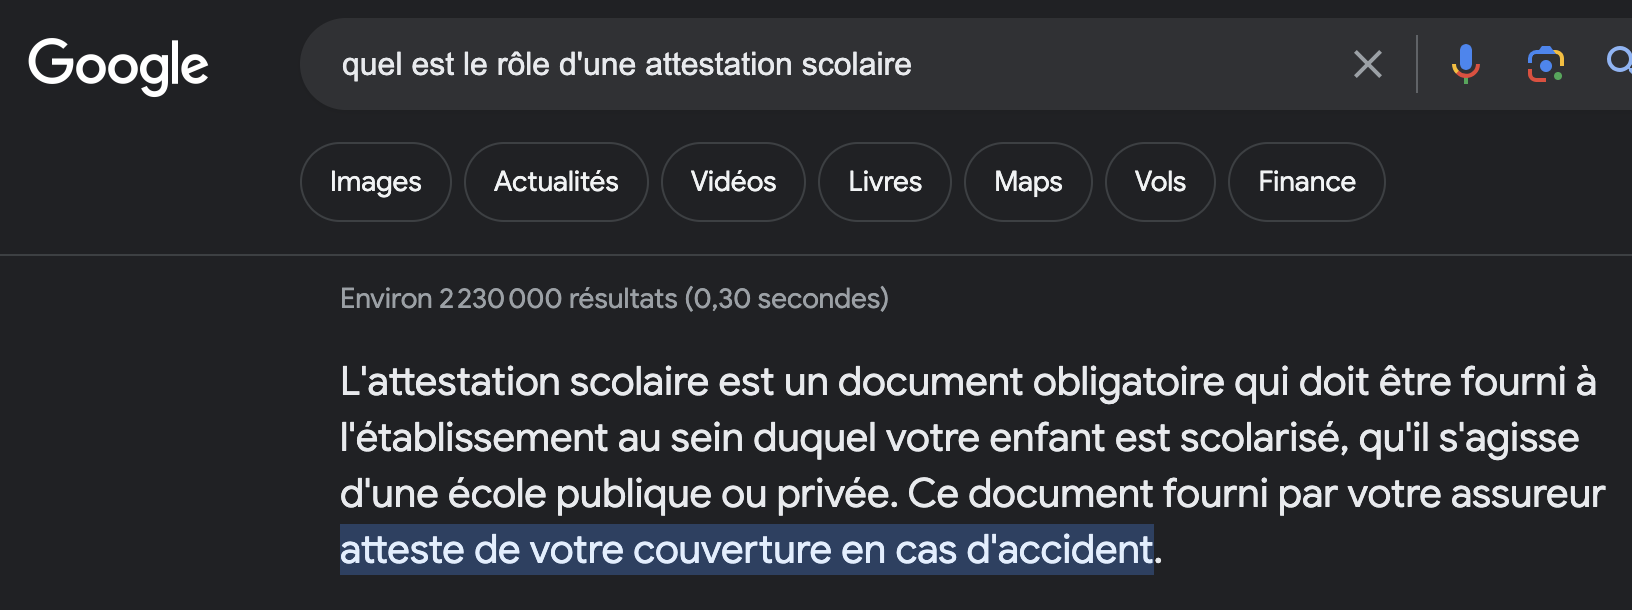